In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models , transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import time


In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



Using device: cuda


In [53]:
# Data Augmentation and Normalization
image_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.RandomRotation(10),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225))]    
)

In [54]:
# Dataset and DataLoader
dataset_path = dataset_path = r"C:\Data_Learnings\Internship2\FreshHarvest_Dataset\FRUIT-16K"
dataset = datasets.ImageFolder(dataset_path,transform=image_transform)
len(dataset)

16000

In [55]:
dataset.classes

['F_Banana',
 'F_Lemon',
 'F_Lulo',
 'F_Mango',
 'F_Orange',
 'F_Strawberry',
 'F_Tamarillo',
 'F_Tomato',
 'S_Banana',
 'S_Lemon',
 'S_Lulo',
 'S_Mango',
 'S_Orange',
 'S_Strawberry',
 'S_Tamarillo',
 'S_Tomato']

In [56]:
num_classes = len(dataset.classes)
num_classes

16

In [57]:
train_size = int(0.7 * len(dataset))
val_size   = int(0.15 * len(dataset))
test_size  = len(dataset) - train_size - val_size
from torch.utils.data import random_split
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size]) # splitting the image dataset into training and validataion dataset

In [58]:
print(len(train_dataset), len(val_dataset), len(test_dataset))


11200 2400 2400


In [59]:
## Data spliiting into training, validation and testing dataset
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True) # saving the images in train_loader
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=True) 
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..0.98422676].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9951199].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8952821..0.9131775].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.90641

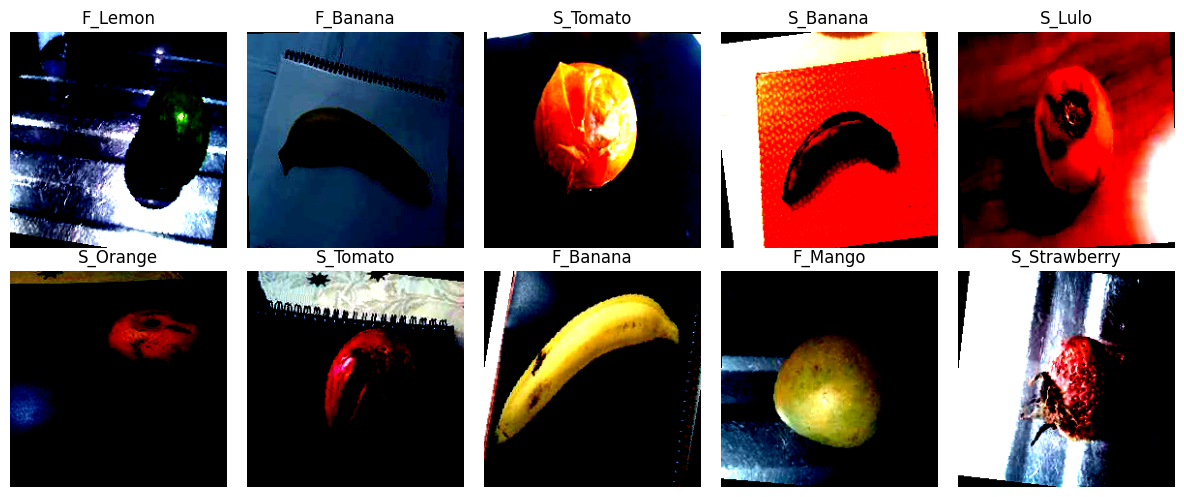

In [60]:
## Data Visualization

images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i, ax in enumerate(axes.flatten()):
    img = images[i].permute(1, 2, 0)
    ax.imshow(img)
    ax.set_title(dataset.classes[labels[i]]
)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [61]:
for images,labels in train_loader:
    print(images.shape) # torch.Size([32, 3, 224, 224]) → batch of 32 images, each with 3 color channels and size 224x224
    print(labels.shape)  # torch.Size([32]) → batch of 32 labels
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [62]:
images[31],labels[31]


(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [63]:
class FruitClassifier(nn.Module):
    def __init__(self,num_classes):
        super(FruitClassifier,self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3,stride = 1,padding=1), # (16,224,224) #Without padding, image size shrinks.
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # (16,112,112) #stride=2 means we are taking 2 steps at a time, so the image size is reduced by half.
            nn.Conv2d(16,32,kernel_size=3,stride = 1,padding=1), # (32,112,112) #Without padding, image size shrinks.
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # (32,56,56)
            nn.Conv2d(32,64,kernel_size=3,stride = 1,padding=1), # (64,56,56) #Without padding, image size shrinks.
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0), # (64,28,28)
            nn.Flatten(),
            nn.Linear(64*28*28,512),
            nn.ReLU(),
            nn.Linear(512,num_classes)
        )



    def forward(self,x):
         x = self.network(x)  
         return x     

In [64]:
model = FruitClassifier(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [65]:
def train(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs):
    import time
    start = time.time()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):

        # ---------- TRAIN ----------
        model.train()
        train_running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = train_running_loss / len(train_loader.dataset)
        epoch_train_acc = 100 * correct_train / total_train

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # ---------- VALIDATION ----------
        model.eval()
        val_running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * images.size(0)

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_acc = 100 * correct_val / total_val

        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        print(f"""
Epoch [{epoch+1}/{num_epochs}]
Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%
Val   Loss: {epoch_val_loss:.4f}, Val   Acc: {epoch_val_acc:.2f}%
        """)

    # ---------- TEST ----------
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    end = time.time()
    print(f"Training completed in {end - start:.2f} seconds")

    return train_losses, val_losses, train_accuracies, val_accuracies



In [66]:
train_losses, val_losses, train_accuracies, val_accuracies = train(
    model,
    train_loader,
    val_loader,
    test_loader,
    criterion,
    optimizer,
    num_epochs =20
)



Epoch [1/20]
Train Loss: 1.3937, Train Acc: 52.39%
Val   Loss: 0.7451, Val   Acc: 73.21%
        

Epoch [2/20]
Train Loss: 0.6305, Train Acc: 78.09%
Val   Loss: 0.4993, Val   Acc: 82.88%
        

Epoch [3/20]
Train Loss: 0.4171, Train Acc: 85.46%
Val   Loss: 0.4087, Val   Acc: 86.08%
        

Epoch [4/20]
Train Loss: 0.3370, Train Acc: 88.63%
Val   Loss: 0.3690, Val   Acc: 87.62%
        

Epoch [5/20]
Train Loss: 0.2531, Train Acc: 91.21%
Val   Loss: 0.2764, Val   Acc: 90.50%
        

Epoch [6/20]
Train Loss: 0.2428, Train Acc: 91.93%
Val   Loss: 0.3075, Val   Acc: 89.96%
        

Epoch [7/20]
Train Loss: 0.1886, Train Acc: 93.47%
Val   Loss: 0.1999, Val   Acc: 93.21%
        

Epoch [8/20]
Train Loss: 0.1780, Train Acc: 94.37%
Val   Loss: 0.2481, Val   Acc: 92.62%
        

Epoch [9/20]
Train Loss: 0.1356, Train Acc: 95.37%
Val   Loss: 0.2059, Val   Acc: 93.29%
        

Epoch [10/20]
Train Loss: 0.1178, Train Acc: 96.27%
Val   Loss: 0.2108, Val   Acc: 93.50%
        

Epoch [1

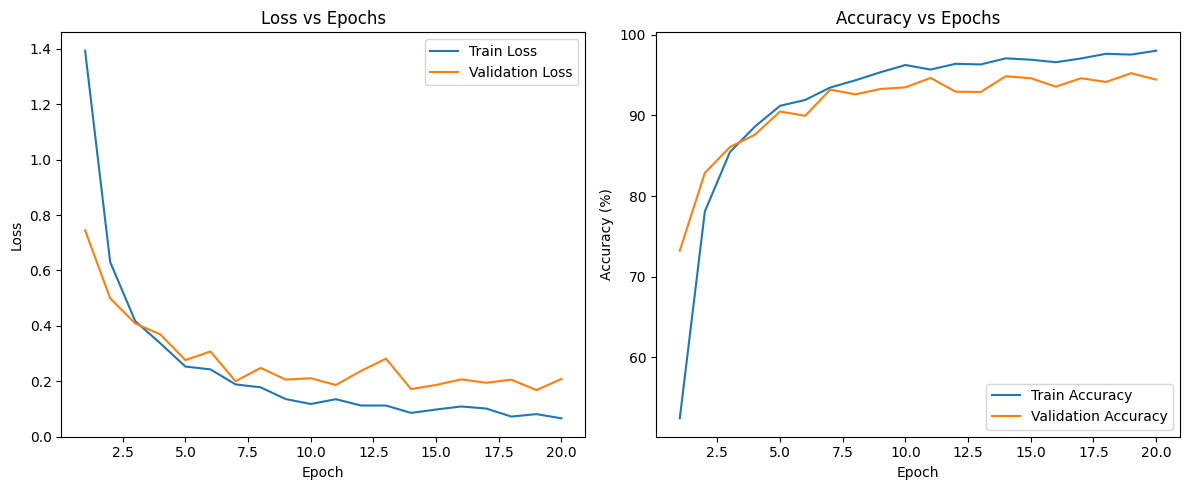

In [67]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))

# -------- LOSS PLOT --------
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()

# -------- ACCURACY PLOT --------
plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epochs")
plt.legend()

plt.tight_layout()
plt.show()
